In [ ]:
import paramiko
import getpass

host = "158.251.88.197"
port = 22
username = "iaraya"
password = getpass.getpass()

ssh = paramiko.SSHClient()
ssh.set_missing_host_key_policy(paramiko.AutoAddPolicy())
ssh.connect(host, port, username, password)

### Loading the instance

In [148]:
from bsg import load_BRinstance,load_BRKGAinstance, load_LargeInstance
from mclp import generate_candidate_solution
import numpy as np

r_param = 100
min_fr = 0.99
max_bl = 10000
bsg_time = 5
i = 1
file_name = "../benchs/Data_Large/L_2500/L_2500_{}.txt".format(i)

# L,W,H,boxes,id2box = load_BRinstance(filename="BR8.txt",inst=4, nbox=1)
# L,W,H,boxes,id2box = load_BRKGAinstance(filename="../benchs/class7/200.txt",inst=1, nbox=1)
L,W,H,boxes,id2box = load_LargeInstance(filename=file_name, nbox=1, rot_allowed=True)
_boxes=boxes.copy()

extra_args = '--greedy_only --max_bl={} --min_fr={}'.format(max_bl, min_fr)

### Solver

In [149]:
from mclp import get_random_bin

def get_adjusted_vol(boxes):
    vol=0.0
    for box in boxes:
        vol += box.adj_vol*boxes[box]
    return vol

def get_vol(boxes):
    vol=0.0
    for box in boxes:
        vol += box.vol*boxes[box]
    return vol
      
def adjusted_swap(solution, n=2,  max_vol_accept=1.0, tolerance=0.1, verbose=True):

    bin_A = get_random_bin(s = solution)
    bin_B = get_random_bin(s = solution, b = bin_A)

    iniA = bin_A.adj_vol
    iniB = bin_B.adj_vol
    var_ini = (bin_A.adj_vol-1.0)**2 + (bin_B.adj_vol-1.0)**2

    nA = int(random.randint(1, n))
    boxes_A = bin_A.pop_random_boxes(nA)
    adjvolA = get_adjusted_vol(boxes_A)

    nB = int(random.randint(0, n))
    boxes_B = bin_B.pop_random_boxes(nB)
    adjvolB = get_adjusted_vol(boxes_B)

    r = tolerance*random.random()
    accepted = False

    if adjvolA > adjvolB and bin_B.adj_vol + adjvolA <= max_vol_accept + r:
        accepted = True
    elif adjvolB > adjvolA and  bin_A.adj_vol + adjvolB <= max_vol_accept + r:
        accepted = True

    if accepted:
        bin_A.insert_boxes(boxes_B)
        bin_B.insert_boxes(boxes_A)
    else: 
        return -10

    var_final = (bin_A.adj_vol-1.0)**2 + (bin_B.adj_vol-1.0)**2

    var_diff = var_final - var_ini

    return var_diff

def get_sorted_vols(solution):
    volumens = []
    for s in solution:
        s_boxes = s.boxes
        vol_boxes = get_vol(s_boxes)/(10**6)
        volumens.append(vol_boxes)

    volumens.sort()
    return volumens

def get_sorted_bins(solution):
    list_solution = list(solution)
    list_solution.sort(key=lambda x: x.vol)
    return list_solution

In [150]:
import time 

initial_time = time.time()
boxes =_boxes.copy()
init_solution = generate_candidate_solution(ssh,L,W,H,boxes,id2box, r_param=r_param, bsg_time=bsg_time , extra_args=extra_args)

last_time = time.time()
execution_time = last_time - initial_time

print("Solution Time {}".format(execution_time))
print("File Name: {}".format(file_name))

Initial Solution: 19
Solution Time 45.623820543289185
File Name: ../benchs/Data_Large/L_2500/L_2500_1.txt


Less Volumen: 6.39512


<AxesSubplot:xlabel='Iterations'>

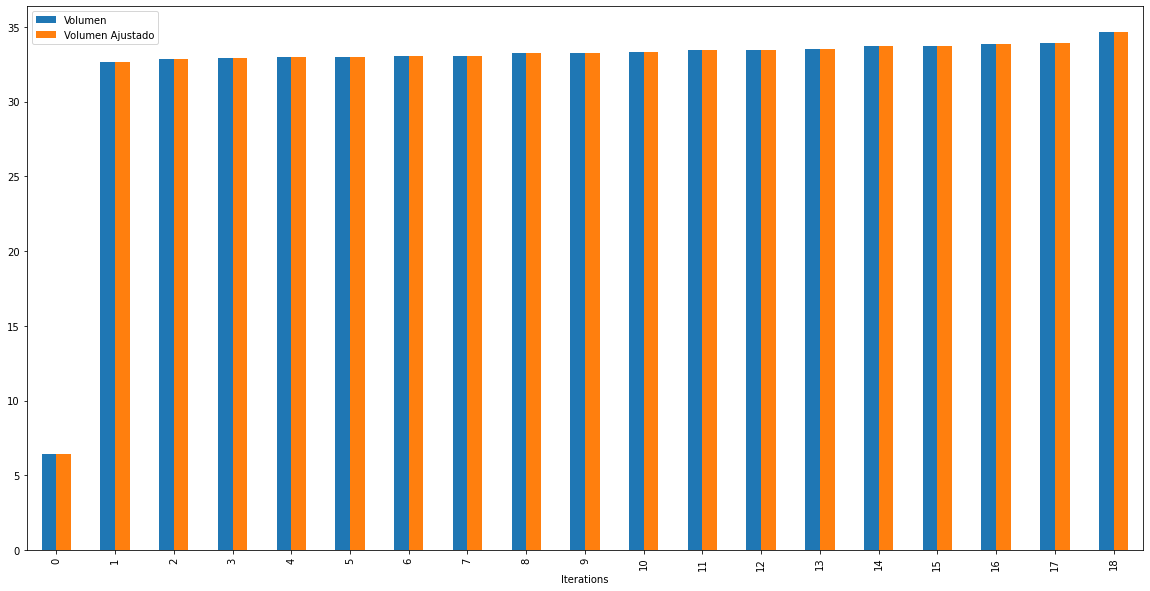

In [151]:
## Plotter solutions
import matplotlib.pyplot as plt
import pandas as pd

bins_to_plot = get_sorted_vols(init_solution)
eje_x = [x for x in range(0,len(bins_to_plot))]


print("Less Volumen: {}".format(bins_to_plot[0]))

columns = pd.DataFrame({
            'Iterations': eje_x,
            'Volumen': bins_to_plot,
            'Volumen Ajustado': bins_to_plot
        })

columns.plot(x='Iterations', y=["Volumen", "Volumen Ajustado"], 
            kind='bar', figsize=(20,10), )


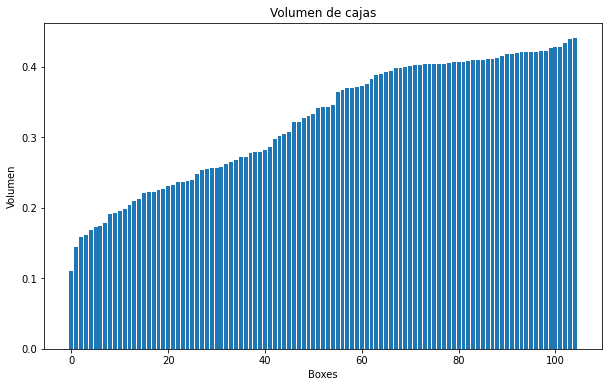

In [152]:
## Plotter solutions
import matplotlib.pyplot as plt

# Se genera el listado para obtener volumenes de cajas
vol_boxes = []

# Se obtiene caja con menor volumen
boxes_to_plot = get_sorted_bins(init_solution)[0].boxes
vol_bin = get_vol(boxes_to_plot)/(10**6)

for box in boxes_to_plot:
    vol_box = (box.vol*boxes_to_plot[box])/(10**6)
    vol_boxes.append(vol_box)

vol_boxes.sort()
eje_x = [x for x in range(0,len(vol_boxes))]

plt.figure(figsize=(10, 6))

plt.title('Volumen de cajas')
plt.xlabel('Boxes')
plt.ylabel('Volumen')


graf = plt.bar(eje_x, vol_boxes)
plt.show()